<a href="https://colab.research.google.com/github/ckrkc/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:

    def __init__(self, data, _childeren=(), _op='', label=''):
      self.data = data
      self.grad = 0.0
      self._prev = set(_childeren)
      self._op = _op
      self.label = label

    def __repr__(self):
      return f"Value(data={self.data})"

    def __add__(self, other):
      out = Value(self.data + other.data, (self, other), '+')
      return out

    def __mul__(self, other):
      out = Value(self.data * other.data, (self, other), '*')
      return out

    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')
      return out

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')

L = d * f; L.label ='L'
L

Value(data=-8.0)

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

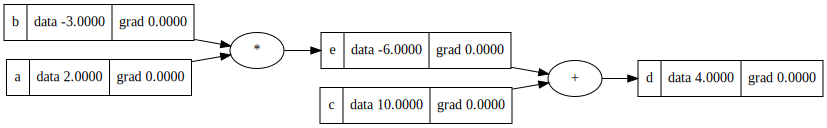

In [ ]:
draw_dot(d)

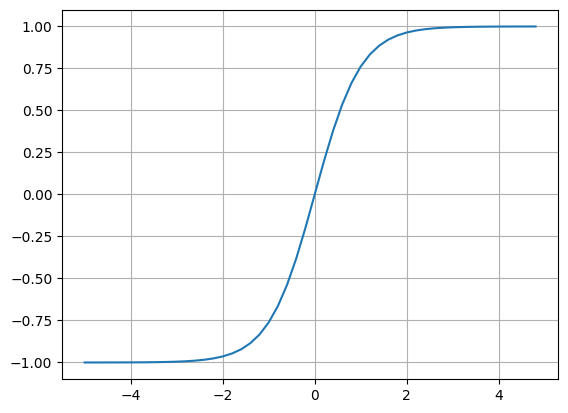

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

### Backpropagation

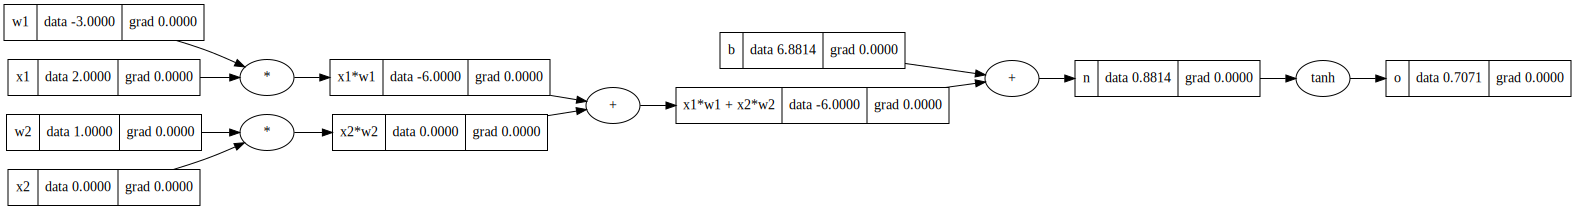

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [ ]:
o.grad = 1.0 #o/do

In [ ]:
# do/dw1 = (do/dn) * (dn/dx1w1) * (dx1w1/dw1)

# n = (x1 * w1) + (x2 * w2) + b
# o = tanh(n)
# derrivative of tanh (hyperbolic tangent function) is: 1 - tanh**2
# do/dn = 1 - o**2

In [ ]:
n.grad = 1 - o.data**2 # do/dn
n.grad = 0.5 # actually 0.4999999999999999

In [ ]:
x1w1x2w2.grad = n.grad * 1.0 # do/dx1w1x2w2 = do/dn(0.5) * dn/dx1w1x2w2(1) = 0.5
b.grad = n.grad * 1.0 # dn/db = do/dn(0.5) * dn/db(1) = 0.5

x1w1.grad = x1w1x2w2.grad * 1.0 # do/dx1w1 = do/dn(0.5) * dn/dx1w1x2w2(1) * dx1w1x2w2/dx1w1(1) = 0.5
x2w2.grad = x1w1x2w2.grad * 1.0 # do/dx2w2 = do/dn(0.5) * dn/dx1w1x2w2(1) * dx1w1x2w2/dx2w2(1) = 0.5

w1.grad = x1w1.grad * x1.data # do/dw1 = do/dn(0.5) * dn/dx1w1x2w2(1) * dx1w1x2w2/dx1w1(1) * dx1w1/dw1(x1) = x1 * 0.5 = 1
w2.grad = x2w2.grad * x2.data # do/dw2 = do/dn(0.5) * dn/dx1w1x2w2(1) * dx1w1x2w2/dx2w2(1) * dx2w2/dw2(x2) = x2 * 0.5 = 1

x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data

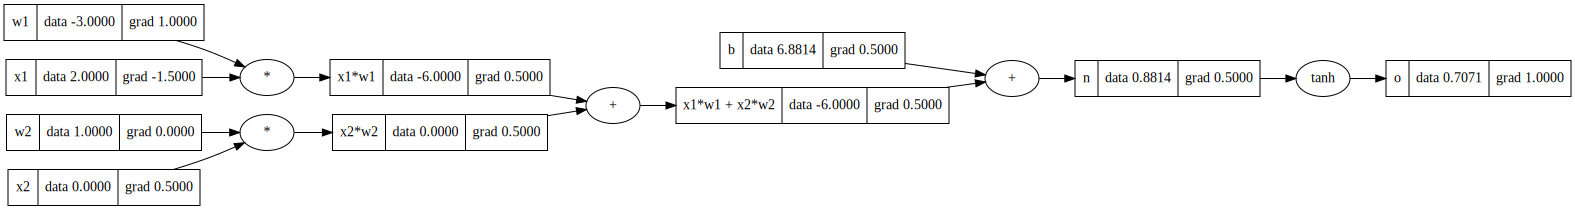

In [ ]:
draw_dot(o)

In [ ]:
print(f'Cost value before update is: {o}')
# decrease w1 0.1 times of it's grad (we're minimizing the cost: 'o')
w1.data = w1.data = w1.data - 0.1 * w1.grad
w1.data

n = x1*w1 + x2*w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
print(f'Cost value after update is: {o}')

Cost value before update is: Value(data=0.7071067811865476)
Cost value after update is: Value(data=0.5924116454357932)


### Next: Implementing the backpropagation function...